In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
#import pytorch for building RNN model
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
#import scaler for normalization
from sklearn.preprocessing import MinMaxScaler

In [2]:
#define a function to split data into train and test sets
def split_data(stock, lookback):
    data_raw = stock # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback+1])
    data = np.array(data);
    
    #split into test and train
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]



In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, n_layers, drop_prob=0.2):
        super(RNN, self).__init__()
        
        #Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        #Defining layers
        #RNN, use dropout to avoid overfitting
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        #Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        #activation function, using RELU to prevent shrinking the gradient
        self.relu = nn.ReLU()
    
    def forward(self, x, h):
        out, h = self.rnn(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self,batch_size):
        #generates the first hidden state of zeros used in the forward pass
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        return hidden
    
def train(train_loader, test_loader, learn_rate, hidden_dim=64, EPOCHS=20, model_type="RNN", loss_func="mse"):
    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    
    # Instantiating the models
    model = RNN(input_dim, hidden_dim, output_dim, n_layers)
    
    # Defining loss function and optimizer
    train_loss = []
    test_loss = []
    if (loss_func == "l1"):
        criterion = nn.L1Loss()
    else:
        criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.perf_counter()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        for x, label in train_loader:
            h = h.data
            model.zero_grad()
            
            out, h = model.forward(x.float(), h)
            loss = criterion(out, label.float())
            loss.backward()
            
            optimizer.step()
            avg_loss += loss.item()
    
        length = len(train_loader)
        avg_loss /= length
        train_loss.append(avg_loss)
        print("Epoch {}/{} Done, Total Training Loss: {}".format(epoch, EPOCHS, avg_loss))
        
        predictions = []
        values = []
        
        h = model.init_hidden(1)
        
        #define loss function criterion
        if(loss_func == "l1"):
            criterion = nn.L1Loss()
        else:
            #default
            criterion = nn.MSELoss()
        
        for x, label in test_loader:
            length = len(test_loader)
            avg_loss2 = 0.
            h = h.data
            model.zero_grad()
            
            out, h = model.forward(x.float(), h)
            loss2 = criterion(out, label.float()).item()
            avg_loss2 += loss2
            
            
            predictions.append(out.detach().numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
            
        test_loss.append(avg_loss2)
        print("Total Testing MSELoss: {}".format(avg_loss2))
        
        current_time = time.perf_counter()
        epoch_times.append(current_time-start_time)
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        print()
    
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model, train_loss, test_loss, predictions, values

def evaluate(model, test_loader, loss_func="mse"):
    with torch.no_grad():
        predictions = []
        values = []
        test_loss = []
        h = model.init_hidden(1)
        if(loss_func == "l1"):
            criterion = nn.L1Loss()
        else:
            criterion = nn.MSELoss()
        for x, label in test_loader:
            h = h.data
            model.zero_grad()
            #print(x.float().shape,h.shape)
            #print(x.float(),h)
            out, h = model.forward(x.float(), h)
            loss = criterion(out, label.float())
            loss = loss.item()
            loss_arr.append(loss)
            predictions.append(out.numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))

    return predictions, values, loss, loss_arr

In [4]:
#data source path
dataset_folder = "../../dataset/"

# Microsoft

In [5]:
#load data
microsoft_df = pd.read_csv(dataset_folder + "microsoft.csv")

In [6]:
#use the close prices for analysis
microsoft_df['Date'] = pd.to_datetime(microsoft_df['Date'])
microsoft_df.set_index('Date',inplace=True)
microsoft_df.drop(columns=['Open','High','Low','Volume'],inplace=True)
microsoft_df

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42
...,...
2021-03-25 16:00:00,232.34
2021-03-26 16:00:00,236.48
2021-03-29 16:00:00,235.24


In [7]:
#normalize the data to the range 0-1
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(microsoft_df.values.reshape(-1,1))
scaled

array([[0.00210064],
       [0.        ],
       [0.00615535],
       ...,
       [0.95236932],
       [0.9358085 ],
       [0.95495848]])

In [8]:
#split the data
lookback = 5 # choose sequence length
train_x,train_y,test_x,test_y = split_data(scaled, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1205, 5, 1)
y_train.shape:  (1205, 1)
X_test.shape:  (301, 5, 1)
y_test.shape:  (301, 1)


In [9]:
#prepare the data to make it suitable for putting into the model
#organize data into batches to make the backpropogation easier
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [10]:
lr = 0.001
rnn_micro, micro_train_mse, micro_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="mse")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.00234563820890184


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Total Testing MSELoss: 0.13735592365264893
Total Time Elapsed: 0.20468173800000056 seconds

Epoch 2/20 Done, Total Training Loss: 0.03638115153257417
Total Testing MSELoss: 0.08634961396455765
Total Time Elapsed: 0.15871254000000068 seconds

Epoch 3/20 Done, Total Training Loss: 0.046524805974882295
Total Testing MSELoss: 0.3988654315471649
Total Time Elapsed: 0.14414177200000022 seconds

Epoch 4/20 Done, Total Training Loss: 0.0191031708307344
Total Testing MSELoss: 0.26966503262519836
Total Time Elapsed: 0.14432133499999988 seconds

Epoch 5/20 Done, Total Training Loss: 0.02072121237270531
Total Testing MSELoss: 0.25509724020957947
Total Time Elapsed: 0.13944812200000012 seconds

Epoch 6/20 Done, Total Training Loss: 0.012840795360814908
Total Testing MSELoss: 0.1375456154346466
Total Time Elapsed: 0.14743405300000045 seconds

Epoch 7/20 Done, Total Training Loss: 0.009005124486066052
Total Testing MSELoss: 0.05105822533369064
Total Time Elapsed: 0.14325305500000063 seconds

Epoch 8/

In [11]:
loss_df = pd.DataFrame(micro_train_mse, columns = ["micro_train_mse"])
loss_df['micro_test_mse'] = micro_test_mse
loss_df

,micro_train_mse,micro_test_mse
0,0.002346,0.137356
1,0.036381,0.086350
2,0.046525,0.398865
3,0.019103,0.269665
4,0.020721,0.255097
5,0.012841,0.137546
6,0.009005,0.051058
7,0.003882,0.023602
8,0.000239,0.023869
9,0.000222,0.012960


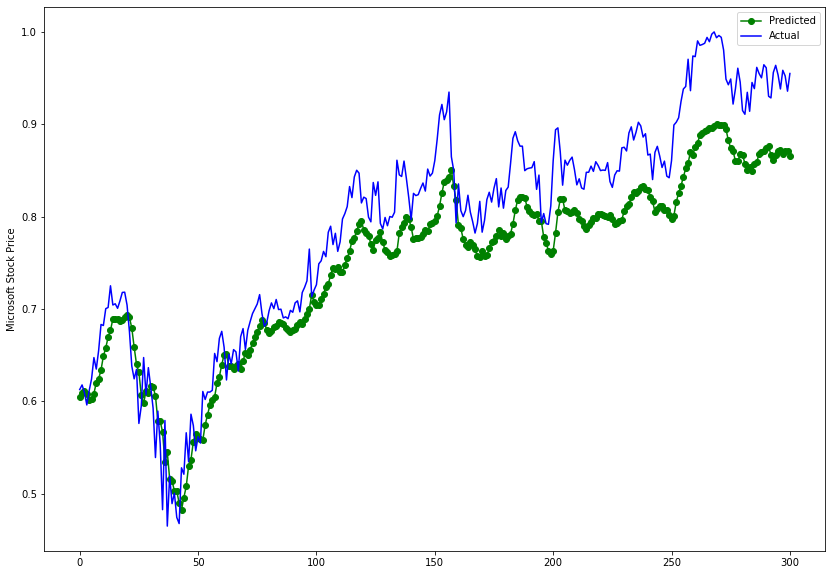

In [12]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Microsoft Stock Price')
plt.legend()

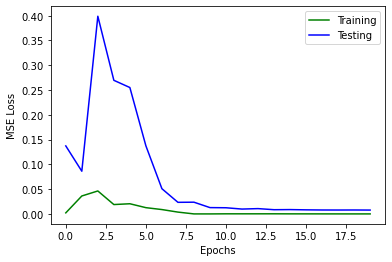

In [13]:
plt.plot(micro_train_mse, color="g", label="Training")
plt.plot(micro_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [14]:
lr = 0.001
rnn_micro2, micro_train_l1, micro_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.038430353513339885
Total Testing MSELoss: 0.44925063848495483
Total Time Elapsed: 0.15559365400000047 seconds

Epoch 2/20 Done, Total Training Loss: 0.20844366408355935
Total Testing MSELoss: 0.6944686770439148
Total Time Elapsed: 0.16070686399999978 seconds

Epoch 3/20 Done, Total Training Loss: 0.1312425067660877
Total Testing MSELoss: 0.5845718383789062
Total Time Elapsed: 0.1391755779999997 seconds

Epoch 4/20 Done, Total Training Loss: 0.1553086482013601
Total Testing MSELoss: 0.6308863162994385
Total Time Elapsed: 0.1485001799999992 seconds

Epoch 5/20 Done, Total Training Loss: 0.12824029606339094
Total Testing MSELoss: 0.5775816440582275
Total Time Elapsed: 0.1429979199999991 seconds

Epoch 6/20 Done, Total Training Loss: 0.1334787996964076
Total Testing MSELoss: 0.5379321575164795
Total Time Elapsed: 0.14614910400000092 seconds

Epoch 7/20 Done, Total Training Loss: 0.10164069711557917
Total Testing MSELoss

In [15]:
loss_df['micro_train_l1'] = micro_train_l1
loss_df['micro_test_l1'] = micro_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1
0,0.002346,0.137356,0.038430,0.449251
1,0.036381,0.086350,0.208444,0.694469
2,0.046525,0.398865,0.131243,0.584572
3,0.019103,0.269665,0.155309,0.630886
4,0.020721,0.255097,0.128240,0.577582
5,0.012841,0.137546,0.133479,0.537932
6,0.009005,0.051058,0.101641,0.343998
7,0.003882,0.023602,0.148523,0.343068
8,0.000239,0.023869,0.092427,0.203812
9,0.000222,0.012960,0.084626,0.178426


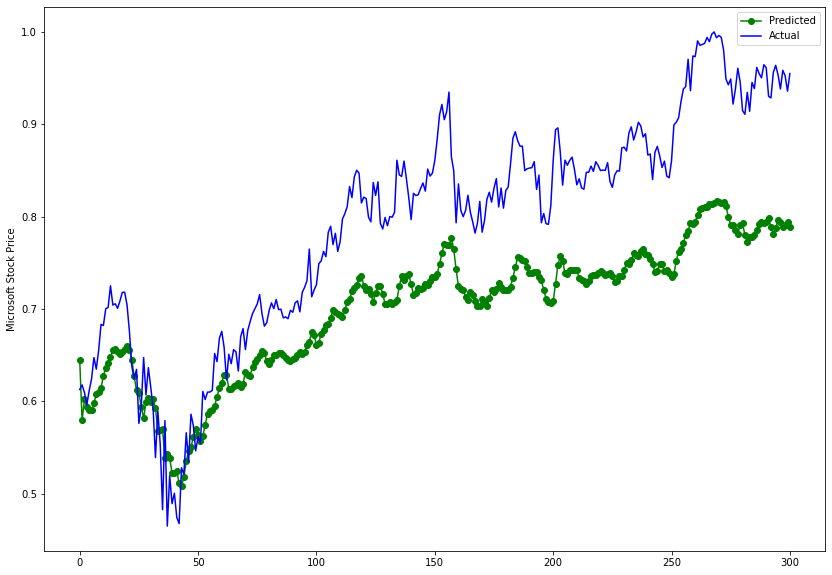

In [16]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Microsoft Stock Price')
plt.legend()

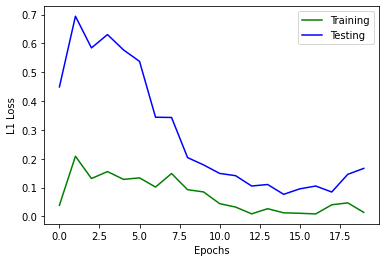

In [17]:
plt.plot(micro_train_l1, color="g", label="Training")
plt.plot(micro_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Artificial Data

In [18]:
art_data = pd.read_csv(dataset_folder +"Artificial_trend.csv")
art_data.set_index('date',inplace=True)
len(art_data)

7307

In [19]:
#normalize the data to the range 0-1
scaler = MinMaxScaler()
scaled_art1 = scaler.fit_transform(art_data.values.reshape(-1,1))
scaled_art1

array([[0.44861011],
       [0.44234504],
       [0.41956507],
       ...,
       [0.38776852],
       [0.4008299 ],
       [0.41748377]])

In [20]:
lookback = 5 # choose sequence length
train_x,train_y,test_x,test_y = split_data(scaled_art1, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (5842, 5, 1)
y_train.shape:  (5842, 1)
X_test.shape:  (1460, 5, 1)
y_test.shape:  (1460, 1)


In [21]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [22]:
lr = 0.001
rnn_art1, art1_train_mse, art1_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.05730248917761555


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Total Testing MSELoss: 0.003498639212921262
Total Time Elapsed: 0.6260090189999996 seconds

Epoch 2/20 Done, Total Training Loss: 0.0348021309447966
Total Testing MSELoss: 0.002630028873682022
Total Time Elapsed: 0.6191715309999992 seconds

Epoch 3/20 Done, Total Training Loss: 0.03840779395937756
Total Testing MSELoss: 0.0034181950613856316
Total Time Elapsed: 0.6062671779999995 seconds

Epoch 4/20 Done, Total Training Loss: 0.029365906901887853
Total Testing MSELoss: 0.00207011541351676
Total Time Elapsed: 0.5994286959999986 seconds

Epoch 5/20 Done, Total Training Loss: 0.0240832237586901
Total Testing MSELoss: 0.004306157119572163
Total Time Elapsed: 0.6077556810000004 seconds

Epoch 6/20 Done, Total Training Loss: 0.017285008109616022
Total Testing MSELoss: 0.011089441366493702
Total Time Elapsed: 0.5956915229999993 seconds

Epoch 7/20 Done, Total Training Loss: 0.010812542663188651
Total Testing MSELoss: 0.007465599104762077
Total Time Elapsed: 0.6115826829999982 seconds

Epoch 8

In [23]:
loss_df['art1_train_mse'] = art1_train_mse
loss_df['art1_test_mse'] = art1_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse
0,0.002346,0.137356,0.038430,0.449251,0.057302,0.003499
1,0.036381,0.086350,0.208444,0.694469,0.034802,0.002630
2,0.046525,0.398865,0.131243,0.584572,0.038408,0.003418
3,0.019103,0.269665,0.155309,0.630886,0.029366,0.002070
4,0.020721,0.255097,0.128240,0.577582,0.024083,0.004306
5,0.012841,0.137546,0.133479,0.537932,0.017285,0.011089
6,0.009005,0.051058,0.101641,0.343998,0.010813,0.007466
7,0.003882,0.023602,0.148523,0.343068,0.004990,0.000001
8,0.000239,0.023869,0.092427,0.203812,0.001256,0.000012
9,0.000222,0.012960,0.084626,0.178426,0.000901,0.000111


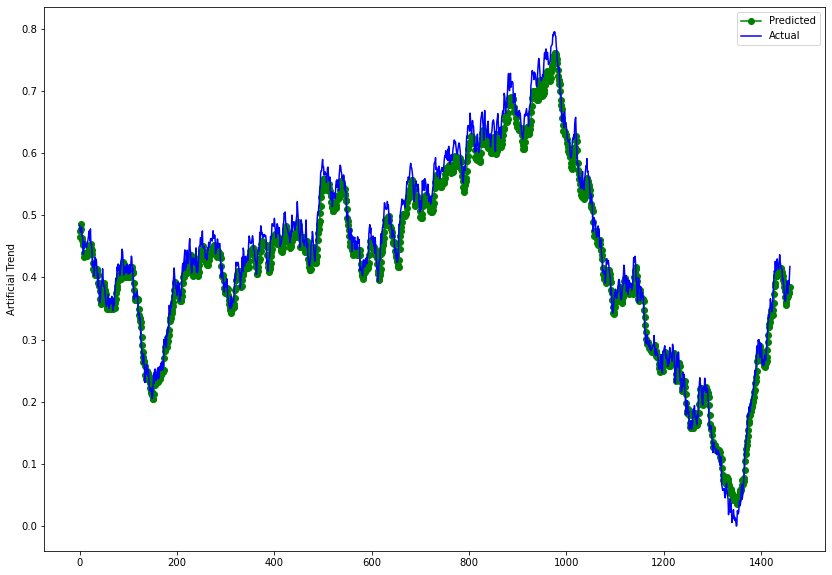

In [24]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artificial Trend')
plt.legend()

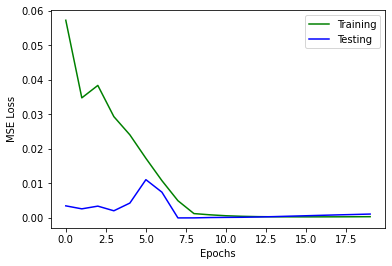

In [25]:
plt.plot(art1_train_mse, color="g", label="Training")
plt.plot(art1_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [26]:
lr = 0.001
rnn_art1_l1, art1_train_l1, art1_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.23086013086140156
Total Testing MSELoss: 0.10119393467903137
Total Time Elapsed: 0.6726012570000002 seconds

Epoch 2/20 Done, Total Training Loss: 0.15902945251910242
Total Testing MSELoss: 0.023795276880264282
Total Time Elapsed: 0.6813890100000002 seconds

Epoch 3/20 Done, Total Training Loss: 0.1255571622565225
Total Testing MSELoss: 0.11255475878715515
Total Time Elapsed: 0.6713366610000016 seconds

Epoch 4/20 Done, Total Training Loss: 0.12035375837605078
Total Testing MSELoss: 0.07907408475875854
Total Time Elapsed: 0.6566406729999983 seconds

Epoch 5/20 Done, Total Training Loss: 0.10135753602198846
Total Testing MSELoss: 0.07286500930786133
Total Time Elapsed: 0.6163116260000017 seconds

Epoch 6/20 Done, Total Training Loss: 0.08636450372472569
Total Testing MSELoss: 0.0031872689723968506
Total Time Elapsed: 0.6275207820000013 seconds

Epoch 7/20 Done, Total Training Loss: 0.06254694743880204
Total Testing M

In [27]:
loss_df['art1_train_l1'] = art1_train_l1
loss_df['art1_test_l1'] = art1_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1
0,0.002346,0.137356,0.038430,0.449251,0.057302,0.003499,0.230860,0.101194
1,0.036381,0.086350,0.208444,0.694469,0.034802,0.002630,0.159029,0.023795
2,0.046525,0.398865,0.131243,0.584572,0.038408,0.003418,0.125557,0.112555
3,0.019103,0.269665,0.155309,0.630886,0.029366,0.002070,0.120354,0.079074
4,0.020721,0.255097,0.128240,0.577582,0.024083,0.004306,0.101358,0.072865
5,0.012841,0.137546,0.133479,0.537932,0.017285,0.011089,0.086365,0.003187
6,0.009005,0.051058,0.101641,0.343998,0.010813,0.007466,0.062547,0.027450
7,0.003882,0.023602,0.148523,0.343068,0.004990,0.000001,0.048340,0.055908
8,0.000239,0.023869,0.092427,0.203812,0.001256,0.000012,0.030065,0.035509
9,0.000222,0.012960,0.084626,0.178426,0.000901,0.000111,0.022975,0.013688


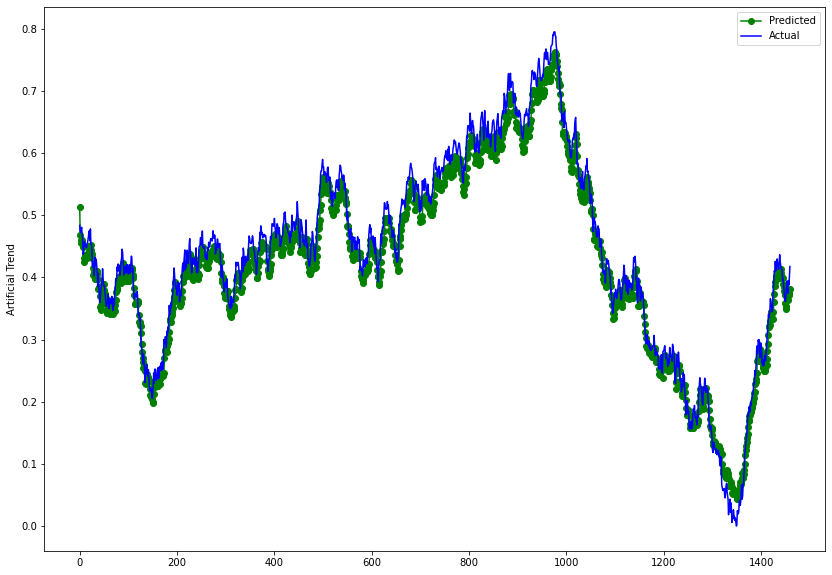

In [28]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artificial Trend')
plt.legend()

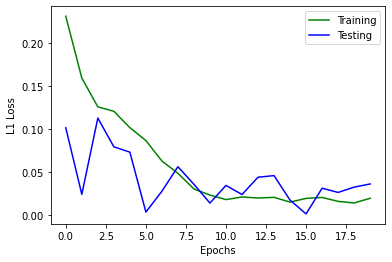

In [29]:
plt.plot(art1_train_l1, color="g", label="Training")
plt.plot(art1_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Crude Oil

In [30]:
oil_data = pd.read_csv(dataset_folder +"oil.csv")
oil_data['DATE'] = pd.to_datetime(oil_data['DATE'])
oil_data.set_index('DATE',inplace=True)
len(oil_data)

1566

In [31]:
oil_data[oil_data['DCOILBRENTEU'] == "."] = np.NaN
oil_data.dropna(inplace=True)
oil_data['DCOILBRENTEU'] = oil_data['DCOILBRENTEU'].astype("float")
oil_data

,DCOILBRENTEU
DATE,
2015-11-02,47.91
2015-11-03,48.00
2015-11-04,46.96
2015-11-05,47.19
2015-11-06,46.09
...,...
2021-10-26,85.11
2021-10-27,84.12
2021-10-28,83.40


In [32]:
#scaling the oil data
scaler = MinMaxScaler()
scaled_oil = scaler.fit_transform(oil_data.values)

train_x,train_y,test_x,test_y = split_data(scaled_oil, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1219, 5, 1)
y_train.shape:  (1219, 1)
X_test.shape:  (305, 5, 1)
y_test.shape:  (305, 1)


In [33]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [34]:
lr = 0.001
rnn_oil, oil_train_mse, oil_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.03560155437260523
Total Testing MSELoss: 0.2605229318141937
Total Time Elapsed: 0.16000122300000186 seconds



/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 2/20 Done, Total Training Loss: 0.025573333204527825
Total Testing MSELoss: 0.22427435219287872
Total Time Elapsed: 0.15382541799999672 seconds

Epoch 3/20 Done, Total Training Loss: 0.03208410372577706
Total Testing MSELoss: 0.17575538158416748
Total Time Elapsed: 0.15116960399999613 seconds

Epoch 4/20 Done, Total Training Loss: 0.030090484559830082
Total Testing MSELoss: 0.16680194437503815
Total Time Elapsed: 0.14300908199999895 seconds

Epoch 5/20 Done, Total Training Loss: 0.04456315564196924
Total Testing MSELoss: 0.07783796638250351
Total Time Elapsed: 0.1508755289999968 seconds

Epoch 6/20 Done, Total Training Loss: 0.04549553487250753
Total Testing MSELoss: 0.04791826382279396
Total Time Elapsed: 0.15318164800000034 seconds

Epoch 7/20 Done, Total Training Loss: 0.04392669636351792
Total Testing MSELoss: 0.03496836870908737
Total Time Elapsed: 0.15416473199999814 seconds

Epoch 8/20 Done, Total Training Loss: 0.03869077137450835
Total Testing MSELoss: 0.0563833825290203

In [35]:
loss_df['oil_train_mse'] = oil_train_mse
loss_df['oil_test_mse'] = oil_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse
0,0.002346,0.137356,0.038430,0.449251,0.057302,0.003499,0.230860,0.101194,0.035602,0.260523
1,0.036381,0.086350,0.208444,0.694469,0.034802,0.002630,0.159029,0.023795,0.025573,0.224274
2,0.046525,0.398865,0.131243,0.584572,0.038408,0.003418,0.125557,0.112555,0.032084,0.175755
3,0.019103,0.269665,0.155309,0.630886,0.029366,0.002070,0.120354,0.079074,0.030090,0.166802
4,0.020721,0.255097,0.128240,0.577582,0.024083,0.004306,0.101358,0.072865,0.044563,0.077838
5,0.012841,0.137546,0.133479,0.537932,0.017285,0.011089,0.086365,0.003187,0.045496,0.047918
6,0.009005,0.051058,0.101641,0.343998,0.010813,0.007466,0.062547,0.027450,0.043927,0.034968
7,0.003882,0.023602,0.148523,0.343068,0.004990,0.000001,0.048340,0.055908,0.038691,0.056383
8,0.000239,0.023869,0.092427,0.203812,0.001256,0.000012,0.030065,0.035509,0.037055,0.037959
9,0.000222,0.012960,0.084626,0.178426,0.000901,0.000111,0.022975,0.013688,0.032009,0.031204


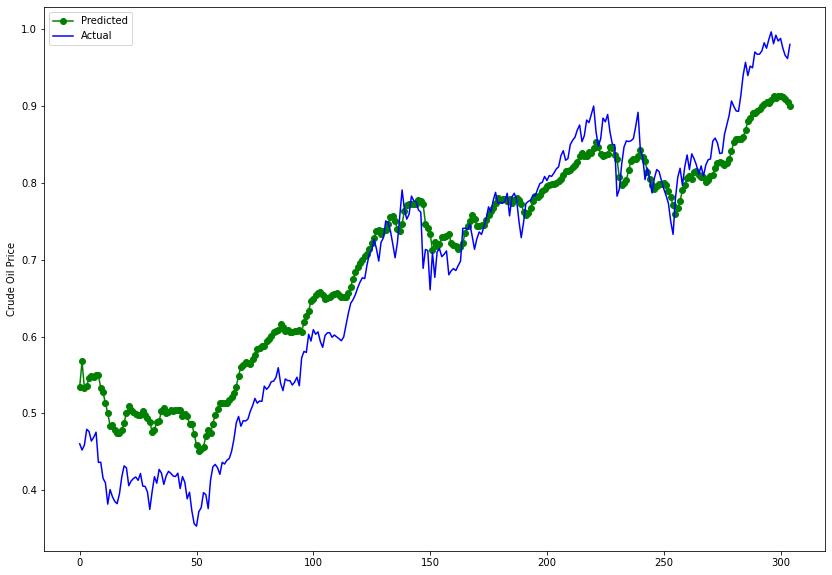

In [36]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Crude Oil Price')
plt.legend()

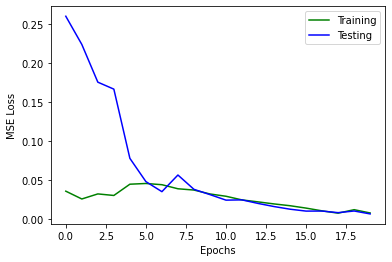

In [37]:
plt.plot(oil_train_mse, color="g", label="Training")
plt.plot(oil_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [38]:
lr = 0.001
rnn_oil2, oil_train_l1, oil_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.2061593998713713
Total Testing MSELoss: 0.4038645029067993
Total Time Elapsed: 0.16157757100000225 seconds

Epoch 2/20 Done, Total Training Loss: 0.10663137035934549
Total Testing MSELoss: 0.4934415817260742
Total Time Elapsed: 0.16093831999999964 seconds

Epoch 3/20 Done, Total Training Loss: 0.17150068871284785
Total Testing MSELoss: 0.36841630935668945
Total Time Elapsed: 0.14952235700000216 seconds

Epoch 4/20 Done, Total Training Loss: 0.1667999907053615
Total Testing MSELoss: 0.28298652172088623
Total Time Elapsed: 0.15073229699999757 seconds

Epoch 5/20 Done, Total Training Loss: 0.1442735742679552
Total Testing MSELoss: 0.25676780939102173
Total Time Elapsed: 0.15948081399999836 seconds

Epoch 6/20 Done, Total Training Loss: 0.15411078420124555
Total Testing MSELoss: 0.2822856903076172
Total Time Elapsed: 0.15303818199999597 seconds

Epoch 7/20 Done, Total Training Loss: 0.1270595268885556
Total Testing MSEL

In [39]:
loss_df['oil_train_l1'] = oil_train_l1
loss_df['oil_test_l1'] = oil_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1
0,0.002346,0.137356,0.038430,0.449251,0.057302,0.003499,0.230860,0.101194,0.035602,0.260523,0.206159,0.403865
1,0.036381,0.086350,0.208444,0.694469,0.034802,0.002630,0.159029,0.023795,0.025573,0.224274,0.106631,0.493442
2,0.046525,0.398865,0.131243,0.584572,0.038408,0.003418,0.125557,0.112555,0.032084,0.175755,0.171501,0.368416
3,0.019103,0.269665,0.155309,0.630886,0.029366,0.002070,0.120354,0.079074,0.030090,0.166802,0.166800,0.282987
4,0.020721,0.255097,0.128240,0.577582,0.024083,0.004306,0.101358,0.072865,0.044563,0.077838,0.144274,0.256768
5,0.012841,0.137546,0.133479,0.537932,0.017285,0.011089,0.086365,0.003187,0.045496,0.047918,0.154111,0.282286
6,0.009005,0.051058,0.101641,0.343998,0.010813,0.007466,0.062547,0.027450,0.043927,0.034968,0.127060,0.296759
7,0.003882,0.023602,0.148523,0.343068,0.004990,0.000001,0.048340,0.055908,0.038691,0.056383,0.131171,0.245159
8,0.000239,0.023869,0.092427,0.203812,0.001256,0.000012,0.030065,0.035509,0.037055,0.037959,0.148365,0.197036
9,0.000222,0.012960,0.084626,0.178426,0.000901,0.000111,0.022975,0.013688,0.032009,0.031204,0.139952,0.202655


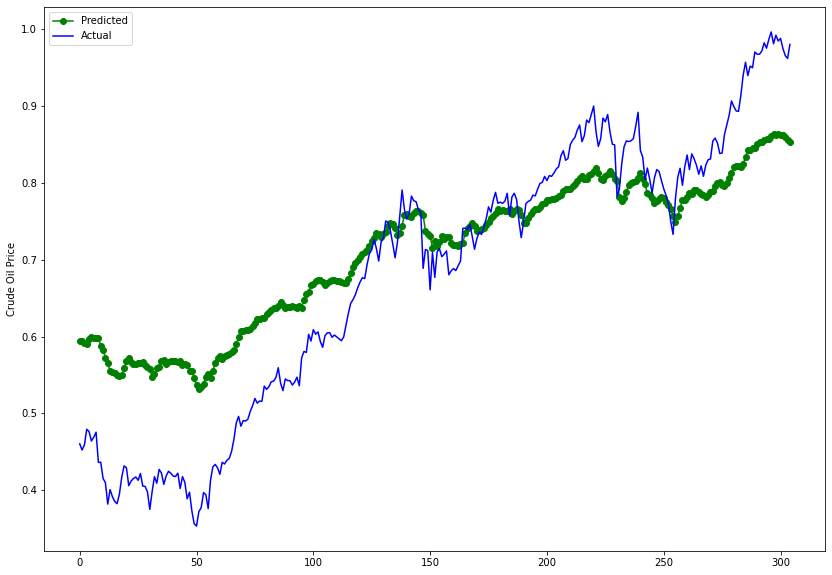

In [40]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Crude Oil Price')
plt.legend()

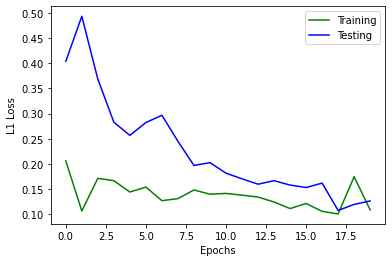

In [41]:
plt.plot(oil_train_l1, color="g", label="Training")
plt.plot(oil_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Bitcoin

In [42]:
coin_df = pd.read_csv(dataset_folder + "coin.csv")
coin_df['Date'] = pd.to_datetime(coin_df['Date'])
coin_df.set_index('Date', inplace=True)
coin_df = pd.DataFrame(coin_df['Close'])
coin_df.dropna(inplace=True)
coin_df

,Close
Date,
2013-04-29 23:59:59,144.539993
2013-04-30 23:59:59,139.000000
2013-05-01 23:59:59,116.989998
2013-05-02 23:59:59,105.209999
2013-05-03 23:59:59,97.750000
...,...
2021-07-02 23:59:59,33897.048590
2021-07-03 23:59:59,34668.548402
2021-07-04 23:59:59,35287.779766


In [43]:
#scaling the coin data
scaler = MinMaxScaler()
scaled_coin = scaler.fit_transform(coin_df.values)

train_x,train_y,test_x,test_y = split_data(scaled_coin, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (2389, 5, 1)
y_train.shape:  (2389, 1)
X_test.shape:  (597, 5, 1)
y_test.shape:  (597, 1)


In [44]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [45]:
lr = 0.001
rnn_coin, coin_train_mse, coin_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.0024252228825119076


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Total Testing MSELoss: 0.16327354311943054
Total Time Elapsed: 0.339482873999998 seconds

Epoch 2/20 Done, Total Training Loss: 0.003910984216368839
Total Testing MSELoss: 0.15078425407409668
Total Time Elapsed: 0.2500593050000006 seconds

Epoch 3/20 Done, Total Training Loss: 0.004215124282308278
Total Testing MSELoss: 0.1612965166568756
Total Time Elapsed: 0.2541352840000002 seconds

Epoch 4/20 Done, Total Training Loss: 0.004618741268033674
Total Testing MSELoss: 0.17114363610744476
Total Time Elapsed: 0.2569157609999948 seconds

Epoch 5/20 Done, Total Training Loss: 0.005606844321231915
Total Testing MSELoss: 0.17183604836463928
Total Time Elapsed: 0.260690278999995 seconds

Epoch 6/20 Done, Total Training Loss: 0.005272502385237757
Total Testing MSELoss: 0.1714467704296112
Total Time Elapsed: 0.25265473199999633 seconds

Epoch 7/20 Done, Total Training Loss: 0.004694741348577883
Total Testing MSELoss: 0.20300960540771484
Total Time Elapsed: 0.25336116399999753 seconds

Epoch 8/20 

In [46]:
loss_df['coin_train_mse'] = coin_train_mse
loss_df['coin_test_mse'] = coin_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse
0,0.002346,0.137356,0.038430,0.449251,0.057302,0.003499,0.230860,0.101194,0.035602,0.260523,0.206159,0.403865,0.002425,0.163274
1,0.036381,0.086350,0.208444,0.694469,0.034802,0.002630,0.159029,0.023795,0.025573,0.224274,0.106631,0.493442,0.003911,0.150784
2,0.046525,0.398865,0.131243,0.584572,0.038408,0.003418,0.125557,0.112555,0.032084,0.175755,0.171501,0.368416,0.004215,0.161297
3,0.019103,0.269665,0.155309,0.630886,0.029366,0.002070,0.120354,0.079074,0.030090,0.166802,0.166800,0.282987,0.004619,0.171144
4,0.020721,0.255097,0.128240,0.577582,0.024083,0.004306,0.101358,0.072865,0.044563,0.077838,0.144274,0.256768,0.005607,0.171836
5,0.012841,0.137546,0.133479,0.537932,0.017285,0.011089,0.086365,0.003187,0.045496,0.047918,0.154111,0.282286,0.005273,0.171447
6,0.009005,0.051058,0.101641,0.343998,0.010813,0.007466,0.062547,0.027450,0.043927,0.034968,0.127060,0.296759,0.004695,0.203010
7,0.003882,0.023602,0.148523,0.343068,0.004990,0.000001,0.048340,0.055908,0.038691,0.056383,0.131171,0.245159,0.004140,0.161783
8,0.000239,0.023869,0.092427,0.203812,0.001256,0.000012,0.030065,0.035509,0.037055,0.037959,0.148365,0.197036,0.003562,0.147453
9,0.000222,0.012960,0.084626,0.178426,0.000901,0.000111,0.022975,0.013688,0.032009,0.031204,0.139952,0.202655,0.003500,0.134089


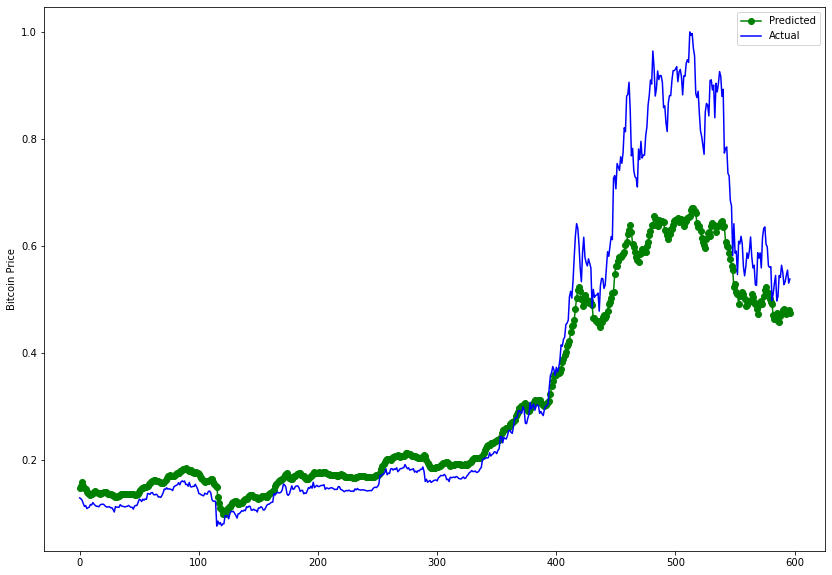

In [47]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Bitcoin Price')
plt.legend()

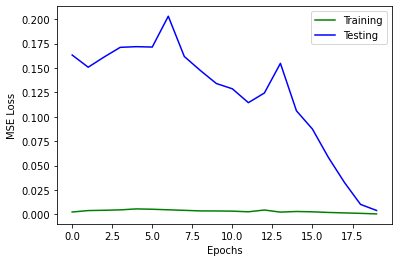

In [48]:
plt.plot(coin_train_mse, color="g", label="Training")
plt.plot(coin_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [49]:
lr = 0.001
rnn_coin2, coin_train_l1, coin_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func = "l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.029172813875374157
Total Testing MSELoss: 0.4205228388309479
Total Time Elapsed: 0.2732440310000044 seconds

Epoch 2/20 Done, Total Training Loss: 0.044944939751027
Total Testing MSELoss: 0.3805813789367676
Total Time Elapsed: 0.25760375899999843 seconds

Epoch 3/20 Done, Total Training Loss: 0.07094133519127059
Total Testing MSELoss: 0.45238590240478516
Total Time Elapsed: 0.25551297899999525 seconds

Epoch 4/20 Done, Total Training Loss: 0.05401961893988522
Total Testing MSELoss: 0.4254556894302368
Total Time Elapsed: 0.26154453500000585 seconds

Epoch 5/20 Done, Total Training Loss: 0.038718231192261386
Total Testing MSELoss: 0.3992644250392914
Total Time Elapsed: 0.27161088999999805 seconds

Epoch 6/20 Done, Total Training Loss: 0.05024919753290109
Total Testing MSELoss: 0.4191354513168335
Total Time Elapsed: 0.28400441699999845 seconds

Epoch 7/20 Done, Total Training Loss: 0.04613985634421477
Total Testing MSE

In [50]:
loss_df['coin_train_l1'] = coin_train_l1
loss_df['coin_test_l1'] = coin_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse,coin_train_l1,coin_test_l1
0,0.002346,0.137356,0.038430,0.449251,0.057302,0.003499,0.230860,0.101194,0.035602,0.260523,0.206159,0.403865,0.002425,0.163274,0.029173,0.420523
1,0.036381,0.086350,0.208444,0.694469,0.034802,0.002630,0.159029,0.023795,0.025573,0.224274,0.106631,0.493442,0.003911,0.150784,0.044945,0.380581
2,0.046525,0.398865,0.131243,0.584572,0.038408,0.003418,0.125557,0.112555,0.032084,0.175755,0.171501,0.368416,0.004215,0.161297,0.070941,0.452386
3,0.019103,0.269665,0.155309,0.630886,0.029366,0.002070,0.120354,0.079074,0.030090,0.166802,0.166800,0.282987,0.004619,0.171144,0.054020,0.425456
4,0.020721,0.255097,0.128240,0.577582,0.024083,0.004306,0.101358,0.072865,0.044563,0.077838,0.144274,0.256768,0.005607,0.171836,0.038718,0.399264
5,0.012841,0.137546,0.133479,0.537932,0.017285,0.011089,0.086365,0.003187,0.045496,0.047918,0.154111,0.282286,0.005273,0.171447,0.050249,0.419135
6,0.009005,0.051058,0.101641,0.343998,0.010813,0.007466,0.062547,0.027450,0.043927,0.034968,0.127060,0.296759,0.004695,0.203010,0.046140,0.358777
7,0.003882,0.023602,0.148523,0.343068,0.004990,0.000001,0.048340,0.055908,0.038691,0.056383,0.131171,0.245159,0.004140,0.161783,0.046992,0.356283
8,0.000239,0.023869,0.092427,0.203812,0.001256,0.000012,0.030065,0.035509,0.037055,0.037959,0.148365,0.197036,0.003562,0.147453,0.077743,0.430598
9,0.000222,0.012960,0.084626,0.178426,0.000901,0.000111,0.022975,0.013688,0.032009,0.031204,0.139952,0.202655,0.003500,0.134089,0.043660,0.403836


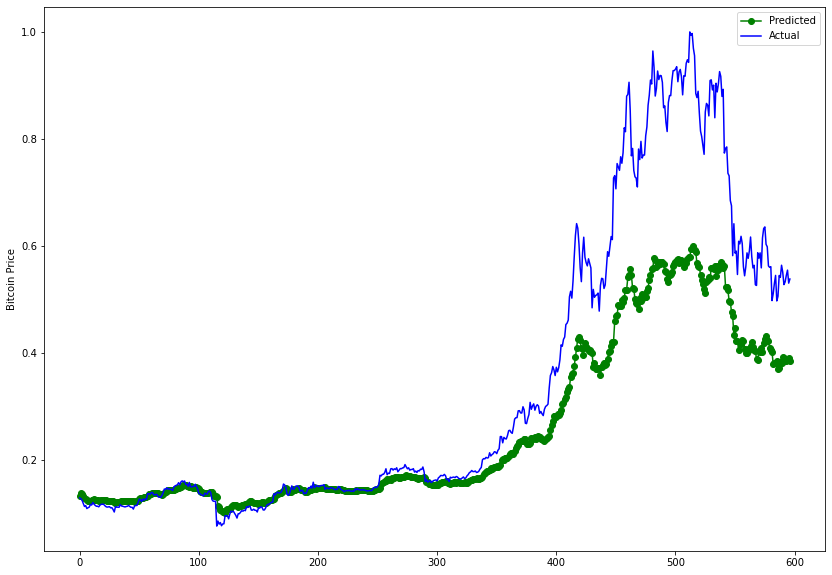

In [51]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Bitcoin Price')
plt.legend()

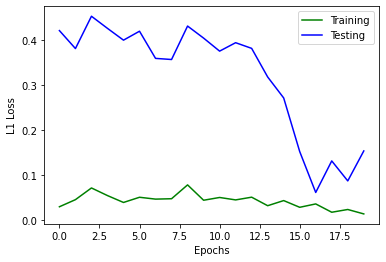

In [52]:
plt.plot(coin_train_l1, color="g", label="Training")
plt.plot(coin_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## S&P500

In [53]:
sp_df = pd.read_csv(dataset_folder + "sp500.csv")
sp_df['Date'] = pd.to_datetime(sp_df['Date'])
sp_df.set_index('Date', inplace=True)
sp_df = pd.DataFrame(sp_df['SP500'])
sp_df.dropna(inplace=True)
sp_df

,SP500
Date,
1871-01-01,4.44
1871-02-01,4.50
1871-03-01,4.61
1871-04-01,4.74
1871-05-01,4.86
...,...
2017-12-01,2664.34
2018-01-01,2789.80
2018-02-01,2705.16


In [54]:
#scaling the s&p data
scaler = MinMaxScaler()
scaled_sp = scaler.fit_transform(sp_df.values)

train_x,train_y,test_x,test_y = split_data(scaled_sp, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1410, 5, 1)
y_train.shape:  (1410, 1)
X_test.shape:  (353, 5, 1)
y_test.shape:  (353, 1)


In [55]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [56]:
lr = 0.001
rnn_sp, sp_train_mse, sp_test_mse, predictions, values = train(train_loader, test_loader, lr, EPOCHS=50, model_type="RNN")

Starting Training of RNN model
Epoch 1/50 Done, Total Training Loss: 0.00017151948068368355
Total Testing MSELoss: 0.7151551246643066
Total Time Elapsed: 0.17896252700000304 seconds



/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 2/50 Done, Total Training Loss: 0.00038711800767385086
Total Testing MSELoss: 0.7044265270233154
Total Time Elapsed: 0.19393736300000342 seconds

Epoch 3/50 Done, Total Training Loss: 0.0003456199818315494
Total Testing MSELoss: 0.7487567663192749
Total Time Elapsed: 0.17468118100000396 seconds

Epoch 4/50 Done, Total Training Loss: 0.0003856414544636457
Total Testing MSELoss: 0.761821448802948
Total Time Elapsed: 0.16710299399999684 seconds

Epoch 5/50 Done, Total Training Loss: 0.0004549692442691625
Total Testing MSELoss: 0.7068138122558594
Total Time Elapsed: 0.17427948200000287 seconds

Epoch 6/50 Done, Total Training Loss: 0.0004010392869650497
Total Testing MSELoss: 0.7158690094947815
Total Time Elapsed: 0.1737348429999983 seconds

Epoch 7/50 Done, Total Training Loss: 0.00044684881503895014
Total Testing MSELoss: 0.7108401656150818
Total Time Elapsed: 0.17654411099999834 seconds

Epoch 8/50 Done, Total Training Loss: 0.00048786857141956057
Total Testing MSELoss: 0.72748339

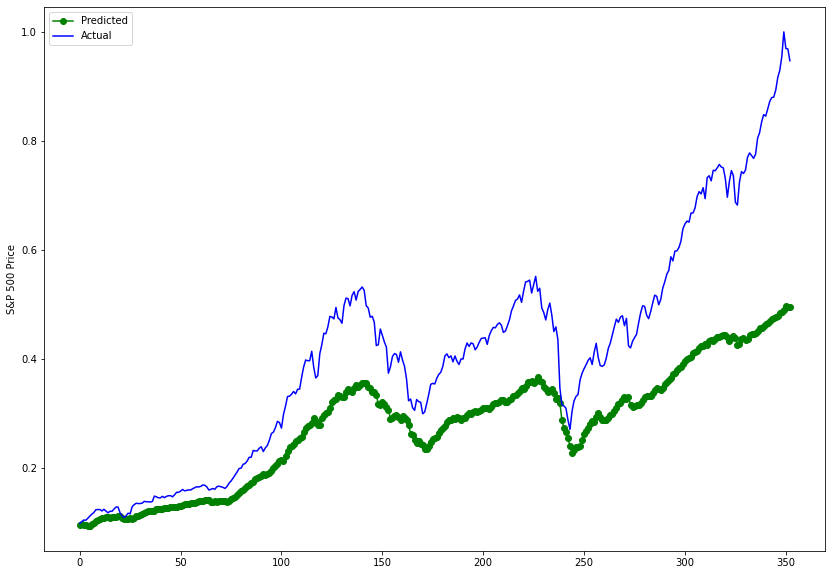

In [57]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('S&P 500 Price')
plt.legend()

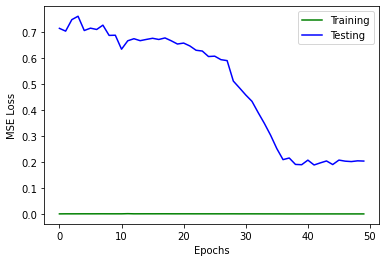

In [58]:
plt.plot(sp_train_mse, color="g", label="Training")
plt.plot(sp_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [59]:
lr = 0.001
rnn_sp2, sp_train_l1, sp_test_l1, predictions, values = train(train_loader, test_loader, lr, EPOCHS=50, model_type="RNN", loss_func = "l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/50 Done, Total Training Loss: 0.006789258198378692
Total Testing MSELoss: 0.907448410987854
Total Time Elapsed: 0.17518740999999238 seconds

Epoch 2/50 Done, Total Training Loss: 0.012495765213812278
Total Testing MSELoss: 0.893328845500946
Total Time Elapsed: 0.1851561040000007 seconds

Epoch 3/50 Done, Total Training Loss: 0.013073010608257557
Total Testing MSELoss: 0.8739889860153198
Total Time Elapsed: 0.17392580599999974 seconds

Epoch 4/50 Done, Total Training Loss: 0.011470149776538496
Total Testing MSELoss: 0.9013898968696594
Total Time Elapsed: 0.1641350060000093 seconds

Epoch 5/50 Done, Total Training Loss: 0.010966839752985503
Total Testing MSELoss: 0.8816930055618286
Total Time Elapsed: 0.17286099800000443 seconds

Epoch 6/50 Done, Total Training Loss: 0.018229968501889907
Total Testing MSELoss: 0.8726847767829895
Total Time Elapsed: 0.17812435400000481 seconds

Epoch 7/50 Done, Total Training Loss: 0.013210130482382903
Total Testing 

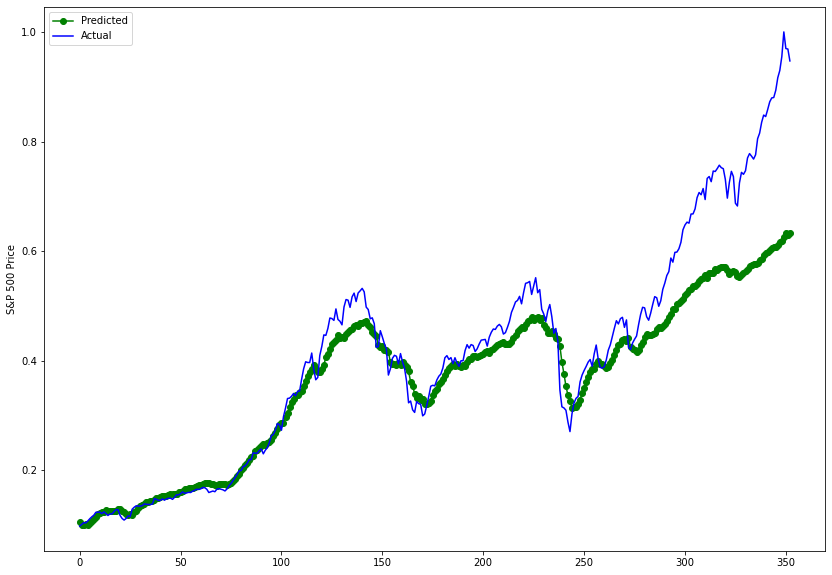

In [60]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('S&P 500 Price')
plt.legend()

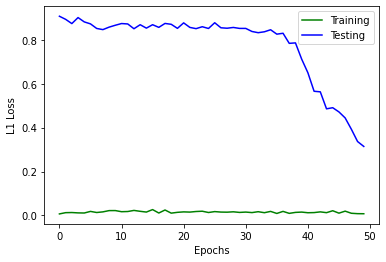

In [61]:
plt.plot(sp_train_l1, color="g", label="Training")
plt.plot(sp_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Artificial Data 2

In [62]:
art2_df = pd.read_csv(dataset_folder + "Artificial_trend1.csv")
art2_df
art2_df['date'] = pd.to_datetime(art2_df['date'])
art2_df.set_index('date', inplace=True)
art2_df.dropna(inplace=True)
art2_df

,trend
date,
2000-07-01,-0.030415
2000-07-02,-0.025551
2000-07-03,-0.029866
2000-07-04,-0.034355
2000-07-05,-0.028927
...,...
2020-06-28,0.044721
2020-06-29,0.046374
2020-06-30,0.048462


In [63]:
#scaling the sencond artificial dataset
scaler = MinMaxScaler()
scaled_art2 = scaler.fit_transform(art2_df.values)

train_x,train_y,test_x,test_y = split_data(scaled_art2, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (5842, 5, 1)
y_train.shape:  (5842, 1)
X_test.shape:  (1460, 5, 1)
y_test.shape:  (1460, 1)


In [64]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running with MSE

In [65]:
lr = 0.001
rnn_art2, art2_train_mse, art2_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.0523191084759054


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Total Testing MSELoss: 0.15005648136138916
Total Time Elapsed: 0.6884926740000026 seconds

Epoch 2/20 Done, Total Training Loss: 0.025874427812056268
Total Testing MSELoss: 0.13237836956977844
Total Time Elapsed: 0.6785053019999907 seconds

Epoch 3/20 Done, Total Training Loss: 0.019625972864949808
Total Testing MSELoss: 0.11074788868427277
Total Time Elapsed: 0.688004785000004 seconds

Epoch 4/20 Done, Total Training Loss: 0.015067969211556304
Total Testing MSELoss: 0.0693739801645279
Total Time Elapsed: 0.674913047000004 seconds

Epoch 5/20 Done, Total Training Loss: 0.008344852112254107
Total Testing MSELoss: 0.036647144705057144
Total Time Elapsed: 0.6507565770000099 seconds

Epoch 6/20 Done, Total Training Loss: 0.0030859005154535214
Total Testing MSELoss: 0.003281504148617387
Total Time Elapsed: 0.6701352129999947 seconds

Epoch 7/20 Done, Total Training Loss: 0.0010458860382601455
Total Testing MSELoss: 0.004360113758593798
Total Time Elapsed: 0.651258734999999 seconds

Epoch 8/

In [66]:
loss_df['art2_train_mse'] = art2_train_mse
loss_df['art2_test_mse'] = art2_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse,coin_train_l1,coin_test_l1,art2_train_mse,art2_test_mse
0,0.002346,0.137356,0.038430,0.449251,0.057302,0.003499,0.230860,0.101194,0.035602,0.260523,0.206159,0.403865,0.002425,0.163274,0.029173,0.420523,0.052319,0.150056
1,0.036381,0.086350,0.208444,0.694469,0.034802,0.002630,0.159029,0.023795,0.025573,0.224274,0.106631,0.493442,0.003911,0.150784,0.044945,0.380581,0.025874,0.132378
2,0.046525,0.398865,0.131243,0.584572,0.038408,0.003418,0.125557,0.112555,0.032084,0.175755,0.171501,0.368416,0.004215,0.161297,0.070941,0.452386,0.019626,0.110748
3,0.019103,0.269665,0.155309,0.630886,0.029366,0.002070,0.120354,0.079074,0.030090,0.166802,0.166800,0.282987,0.004619,0.171144,0.054020,0.425456,0.015068,0.069374
4,0.020721,0.255097,0.128240,0.577582,0.024083,0.004306,0.101358,0.072865,0.044563,0.077838,0.144274,0.256768,0.005607,0.171836,0.038718,0.399264,0.008345,0.036647
5,0.012841,0.137546,0.133479,0.537932,0.017285,0.011089,0.086365,0.003187,0.045496,0.047918,0.154111,0.282286,0.005273,0.171447,0.050249,0.419135,0.003086,0.003282
6,0.009005,0.051058,0.101641,0.343998,0.010813,0.007466,0.062547,0.027450,0.043927,0.034968,0.127060,0.296759,0.004695,0.203010,0.046140,0.358777,0.001046,0.004360
7,0.003882,0.023602,0.148523,0.343068,0.004990,0.000001,0.048340,0.055908,0.038691,0.056383,0.131171,0.245159,0.004140,0.161783,0.046992,0.356283,0.000781,0.002041
8,0.000239,0.023869,0.092427,0.203812,0.001256,0.000012,0.030065,0.035509,0.037055,0.037959,0.148365,0.197036,0.003562,0.147453,0.077743,0.430598,0.000595,0.002190
9,0.000222,0.012960,0.084626,0.178426,0.000901,0.000111,0.022975,0.013688,0.032009,0.031204,0.139952,0.202655,0.003500,0.134089,0.043660,0.403836,0.000529,0.002115


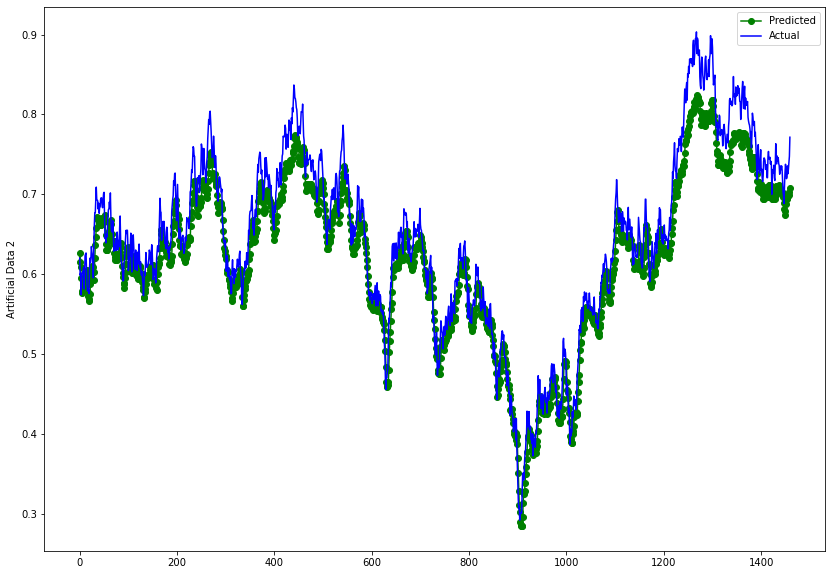

In [67]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artificial Data 2')
plt.legend()

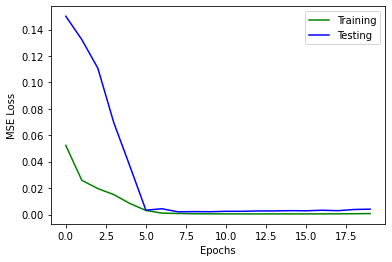

In [68]:
plt.plot(art2_train_mse, color="g", label="Training")
plt.plot(art2_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running with L1 Loss

In [69]:
lr = 0.001
rnn_art2_2, art2_train_l1, art2_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func = "l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.1879637518713435
Total Testing MSELoss: 0.47068625688552856
Total Time Elapsed: 0.6250731429999945 seconds

Epoch 2/20 Done, Total Training Loss: 0.148057923662466
Total Testing MSELoss: 0.3778896927833557
Total Time Elapsed: 0.6312147059999944 seconds

Epoch 3/20 Done, Total Training Loss: 0.11109690258668346
Total Testing MSELoss: 0.2971983551979065
Total Time Elapsed: 0.6195164309999939 seconds

Epoch 4/20 Done, Total Training Loss: 0.059326781696834405
Total Testing MSELoss: 0.18730801343917847
Total Time Elapsed: 0.6345702449999919 seconds

Epoch 5/20 Done, Total Training Loss: 0.03847013454843354
Total Testing MSELoss: 0.12742525339126587
Total Time Elapsed: 0.6203118809999921 seconds

Epoch 6/20 Done, Total Training Loss: 0.03549454178006112
Total Testing MSELoss: 0.1277916431427002
Total Time Elapsed: 0.6161382499999917 seconds

Epoch 7/20 Done, Total Training Loss: 0.04038843075529887
Total Testing MSELoss:

In [70]:
loss_df['art2_train_l1'] = art2_train_l1
loss_df['art2_test_l1'] = art2_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse,coin_train_l1,coin_test_l1,art2_train_mse,art2_test_mse,art2_train_l1,art2_test_l1
0,0.002346,0.137356,0.038430,0.449251,0.057302,0.003499,0.230860,0.101194,0.035602,0.260523,0.206159,0.403865,0.002425,0.163274,0.029173,0.420523,0.052319,0.150056,0.187964,0.470686
1,0.036381,0.086350,0.208444,0.694469,0.034802,0.002630,0.159029,0.023795,0.025573,0.224274,0.106631,0.493442,0.003911,0.150784,0.044945,0.380581,0.025874,0.132378,0.148058,0.377890
2,0.046525,0.398865,0.131243,0.584572,0.038408,0.003418,0.125557,0.112555,0.032084,0.175755,0.171501,0.368416,0.004215,0.161297,0.070941,0.452386,0.019626,0.110748,0.111097,0.297198
3,0.019103,0.269665,0.155309,0.630886,0.029366,0.002070,0.120354,0.079074,0.030090,0.166802,0.166800,0.282987,0.004619,0.171144,0.054020,0.425456,0.015068,0.069374,0.059327,0.187308
4,0.020721,0.255097,0.128240,0.577582,0.024083,0.004306,0.101358,0.072865,0.044563,0.077838,0.144274,0.256768,0.005607,0.171836,0.038718,0.399264,0.008345,0.036647,0.038470,0.127425
5,0.012841,0.137546,0.133479,0.537932,0.017285,0.011089,0.086365,0.003187,0.045496,0.047918,0.154111,0.282286,0.005273,0.171447,0.050249,0.419135,0.003086,0.003282,0.035495,0.127792
6,0.009005,0.051058,0.101641,0.343998,0.010813,0.007466,0.062547,0.027450,0.043927,0.034968,0.127060,0.296759,0.004695,0.203010,0.046140,0.358777,0.001046,0.004360,0.040388,0.164529
7,0.003882,0.023602,0.148523,0.343068,0.004990,0.000001,0.048340,0.055908,0.038691,0.056383,0.131171,0.245159,0.004140,0.161783,0.046992,0.356283,0.000781,0.002041,0.034066,0.130273
8,0.000239,0.023869,0.092427,0.203812,0.001256,0.000012,0.030065,0.035509,0.037055,0.037959,0.148365,0.197036,0.003562,0.147453,0.077743,0.430598,0.000595,0.002190,0.036665,0.152788
9,0.000222,0.012960,0.084626,0.178426,0.000901,0.000111,0.022975,0.013688,0.032009,0.031204,0.139952,0.202655,0.003500,0.134089,0.043660,0.403836,0.000529,0.002115,0.028398,0.110541


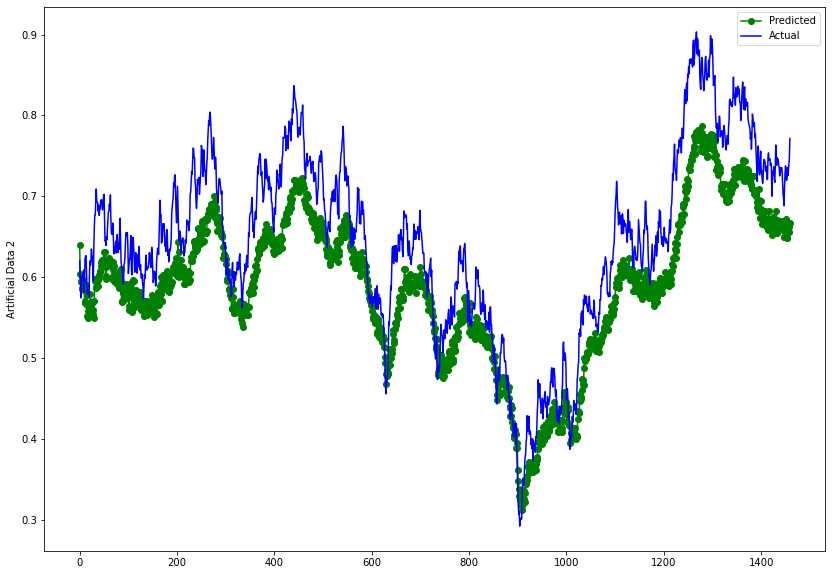

In [71]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artificial Data 2')
plt.legend()

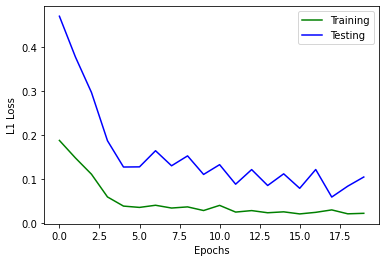

In [72]:
plt.plot(art2_train_l1, color="g", label="Training")
plt.plot(art2_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## 